In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


I Want to see real quick some comparison stats between some models (chosen or not)

In [5]:
df = pd.read_csv("/files/fpl-points-predictor/data/processed/players_all_seasons.csv")
df.head()


,id,name,team,position,minutes,goals_scored,assists,goals_conceded,clean_sheets,saves,...,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,influence,creativity,threat,ict_index,total_points,season
0,3,Granit Xhaka,Arsenal,MID,2992,7,8,35,13,0,...,4.65,3.89,8.54,36.52,647.0,673.3,498.0,182.0,153.0,2022-23
1,4,Mohamed Elneny,Arsenal,MID,111,0,0,2,0,0,...,0.00,0.04,0.04,1.29,4.6,5.4,0.0,1.1,6.0,2022-23
2,5,Rob Holding,Arsenal,DEF,562,1,0,13,0,0,...,0.32,0.15,0.47,11.14,152.0,10.3,54.0,21.6,21.0,2022-23
3,6,Thomas Partey,Arsenal,MID,2480,3,0,28,11,0,...,2.59,2.17,4.76,32.27,513.2,439.6,240.0,119.5,86.0,2022-23
4,7,Martin Ødegaard,Arsenal,MID,3132,15,8,38,13,0,...,9.75,8.02,17.77,37.94,960.0,1100.4,920.0,298.3,212.0,2022-23


In [20]:
import pandas as pd
import numpy as np

# Column name for the player identifier
player_col = "id"  # change to "player_id" if that's how it's called in your df

df["season"].unique()


array(['2022-23', '2023-24', '2024-25'], dtype=object)

In [6]:
feature_cols = [
    "minutes", "goals_scored", "assists",
    "expected_goals", "expected_assists",
    "yellow_cards", "red_cards",
]

X = df[feature_cols]
y = df["total_points"]


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [9]:
models = {
    "Linear": LinearRegression(),
    "Ridge 1.0": Ridge(alpha=1.0),
    "Lasso 0.1": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GBM": GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    results[name] = mae

results


{'Linear': 3.894399398935097,
 'Ridge 1.0': 3.8911257300606548,
 'Lasso 0.1': 3.8478769632948615,
 'RandomForest': 3.9313216361943732,
 'GBM': 3.7317543592070277}

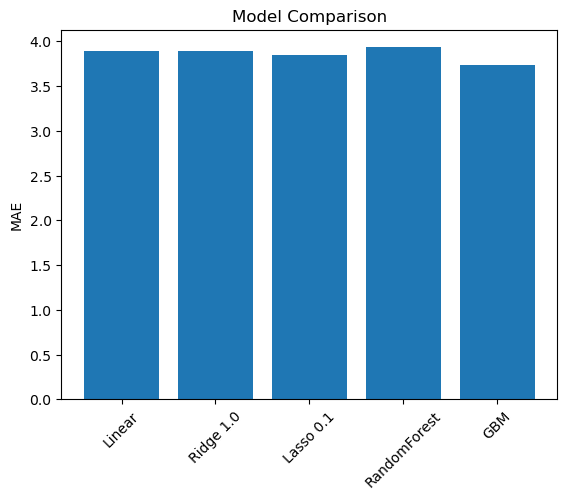

In [10]:
plt.bar(results.keys(), results.values())
plt.ylabel("MAE")
plt.title("Model Comparison")
plt.xticks(rotation=45)
plt.show()


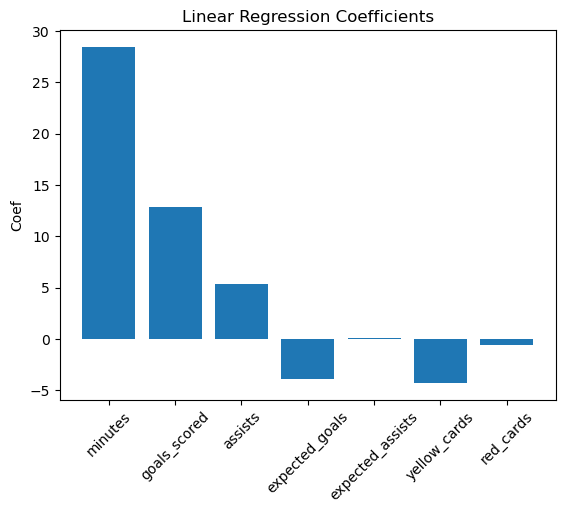

In [11]:
lin = LinearRegression()
lin.fit(X_train, y_train)

plt.bar(feature_cols, lin.coef_)
plt.xticks(rotation=45)
plt.ylabel("Coef")
plt.title("Linear Regression Coefficients")
plt.show()


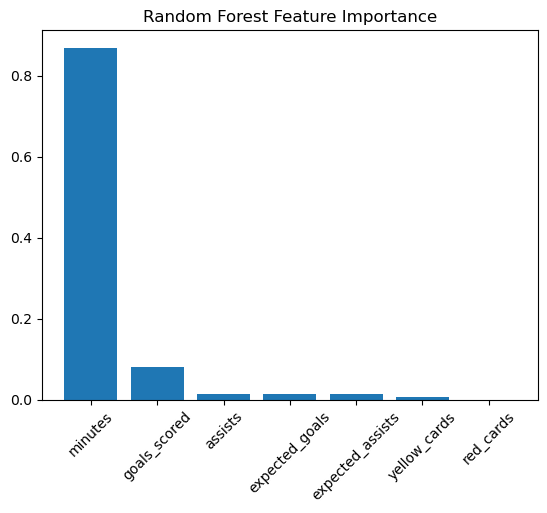

In [12]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

plt.bar(feature_cols, rf.feature_importances_)
plt.xticks(rotation=45)
plt.title("Random Forest Feature Importance")
plt.show()


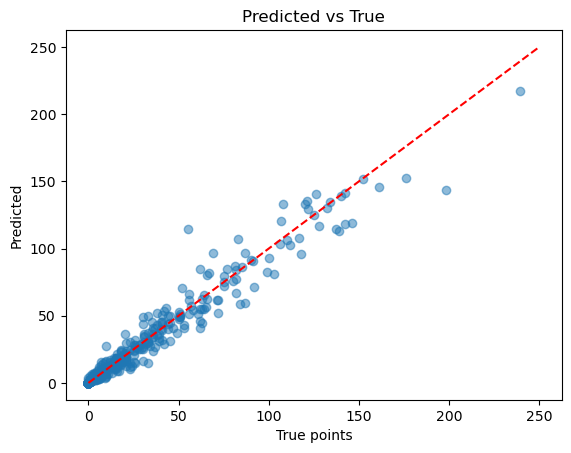

In [13]:
best_model = RandomForestRegressor(n_estimators=300, random_state=42)
best_model.fit(X_train, y_train)

pred = best_model.predict(X_test)

plt.scatter(y_test, pred, alpha=0.5)
plt.xlabel("True points")
plt.ylabel("Predicted")
plt.title("Predicted vs True")
plt.plot([0,250],[0,250], "r--")
plt.show()


This results are not realistic because we use end season informations... Now firstly we will test only on the 24-25 season (irrealistic prediction because again there are informations "from the future") and then we will make a realistic prediction with the "lagged model".

In [14]:
df["season"].unique()


array(['2022-23', '2023-24', '2024-25'], dtype=object)

In [15]:
# Train = seasons 22-23 and 23-24
train_df = df[df["season"].isin(["2022-23", "2023-24"])].copy()

# Test = season 24-25
test_df = df[df["season"] == "2024-25"].copy()

print(train_df["season"].value_counts())
print(test_df["season"].value_counts())


season
2022-23    778
2023-24    769
Name: count, dtype: int64
season
2024-25    661
Name: count, dtype: int64


In [16]:
feature_cols = [
    "minutes", "goals_scored", "assists",
    "expected_goals", "expected_assists",
    "yellow_cards", "red_cards",
]

target_col = "total_points"

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

models = {
    "Linear": LinearRegression(),
    "Ridge 1.0": Ridge(alpha=1.0),
    "Lasso 0.1": Lasso(alpha=0.1),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GBM": GradientBoostingRegressor(random_state=42),
}

results_season_split = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, preds)
    results_season_split[name] = mae

results_season_split



{'Linear': 1.8600973316545415,
 'Ridge 1.0': 1.8640599266355125,
 'Lasso 0.1': 1.8775075912948505,
 'RandomForest': 2.244378646798654,
 'GBM': 2.15305379073684}

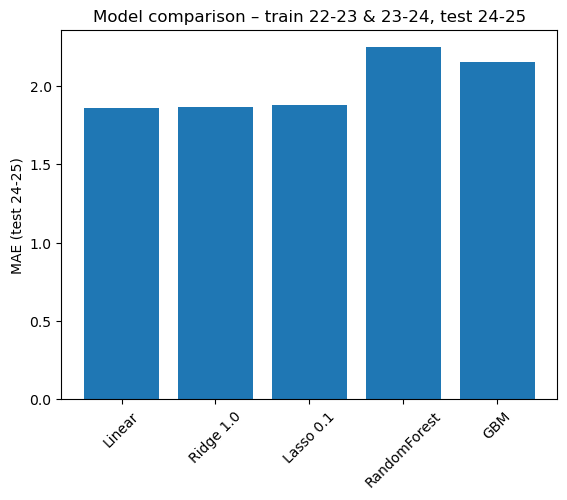

In [19]:
import matplotlib.pyplot as plt

plt.bar(results_season_split.keys(), results_season_split.values())
plt.ylabel("MAE (test 24-25)")
plt.title("Model comparison – train 22-23 & 23-24, test 24-25")
plt.xticks(rotation=45)
plt.show()


In [21]:
season_to_prev = {
    "2022-23": None,
    "2023-24": "2022-23",
    "2024-25": "2023-24",
}

df["prev_season"] = df["season"].map(season_to_prev)
df[["season", "prev_season"]].drop_duplicates()


,season,prev_season
0,2022-23,None
778,2023-24,2022-23
1547,2024-25,2023-24


In [22]:
# Re-use (or define) your feature columns at season level
feature_cols = [
    "minutes", "goals_scored", "assists",
    "expected_goals", "expected_assists",
    "yellow_cards", "red_cards",
]

# Keep only what we need for the "previous season" table
df_prev = df[[player_col, "season"] + feature_cols + ["total_points"]].copy()

# Rename: season -> prev_season, features -> prev_*, target -> prev_total_points
rename_map = {"season": "prev_season"}
rename_map.update({col: f"prev_{col}" for col in feature_cols + ["total_points"]})

df_prev = df_prev.rename(columns=rename_map)

df_prev.head()


,id,prev_season,prev_minutes,prev_goals_scored,prev_assists,prev_expected_goals,prev_expected_assists,prev_yellow_cards,prev_red_cards,prev_total_points
0,3,2022-23,2992,7,8,4.65,3.89,4,0,153.0
1,4,2022-23,111,0,0,0.00,0.04,0,0,6.0
2,5,2022-23,562,1,0,0.32,0.15,0,0,21.0
3,6,2022-23,2480,3,0,2.59,2.17,5,0,86.0
4,7,2022-23,3132,15,8,9.75,8.02,4,0,212.0


In [23]:
df_merged = df.merge(
    df_prev,
    on=[player_col, "prev_season"],
    how="left",
)

df_merged[[player_col, "season", "prev_season", "total_points", "prev_total_points"]].head()


,id,season,prev_season,total_points,prev_total_points
0,3,2022-23,None,153.0,NaN
1,4,2022-23,None,6.0,NaN
2,5,2022-23,None,21.0,NaN
3,6,2022-23,None,86.0,NaN
4,7,2022-23,None,212.0,NaN


In [24]:
needed_prev_cols = [f"prev_{col}" for col in feature_cols]

model_df = df_merged.dropna(subset=needed_prev_cols)

model_df[["season", "prev_season"]].drop_duplicates()


,season,prev_season
778,2023-24,2022-23
1547,2024-25,2023-24


In [25]:
feature_cols_lagged = [f"prev_{col}" for col in feature_cols] + ["prev_total_points"]
target_col = "total_points"

train_mask = model_df["season"] == "2023-24"   # utilise features 22-23
test_mask = model_df["season"] == "2024-25"    # utilise features 23-24

X_train = model_df.loc[train_mask, feature_cols_lagged]
y_train = model_df.loc[train_mask, target_col]

X_test = model_df.loc[test_mask, feature_cols_lagged]
y_test = model_df.loc[test_mask, target_col]

X_train.shape, X_test.shape


((769, 8), (660, 8))

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

models_lag_season = {
    "Linear (lag season)": LinearRegression(),
    "Ridge 1.0 (lag season)": Ridge(alpha=1.0),
    "Lasso 0.1 (lag season)": Lasso(alpha=0.1),
    "RandomForest (lag season)": RandomForestRegressor(n_estimators=200, random_state=42),
    "GBM (lag season)": GradientBoostingRegressor(random_state=42),
}

results_lag_season = {}

for name, model in models_lag_season.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, preds)
    results_lag_season[name] = mae

results_lag_season


{'Linear (lag season)': 13.078872920761354,
 'Ridge 1.0 (lag season)': 13.080544748846892,
 'Lasso 0.1 (lag season)': 13.15886014649466,
 'RandomForest (lag season)': 14.065038044505275,
 'GBM (lag season)': 13.351585262343415}

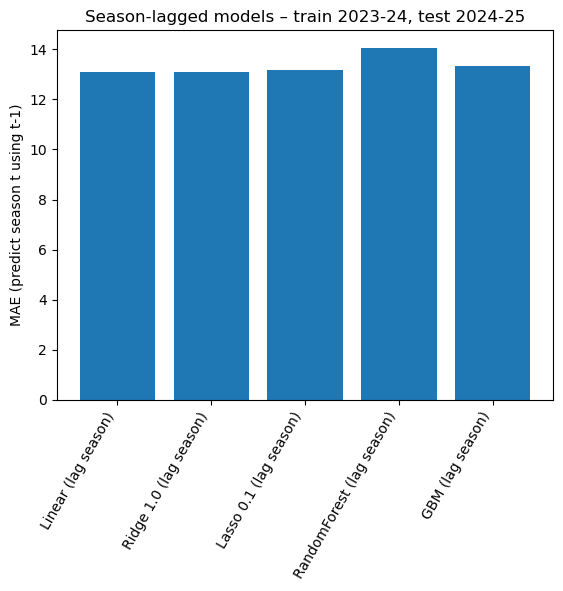

In [28]:
import matplotlib.pyplot as plt

plt.bar(results_lag_season.keys(), results_lag_season.values())
plt.ylabel("MAE (predict season t using t-1)")
plt.title("Season-lagged models – train 2023-24, test 2024-25")
plt.xticks(rotation=60, ha="right")
plt.show()


Here are realistic MAE values because of the true prediction model we used. With these results I choose to replace the RandomForest model by the Gradient boosting one.